# Image Postprocessing of Cavitation Images

This program loads Raw movie data from Chronos of 10x microscope pMDI sprays with cutaway orifice.

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 25/04/2024
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os, copy
import matplotlib.pyplot as plt
%matplotlib widget

## Load image sequence

In [14]:
# Define where images come from.
src_dir = "/Volumes/DUKE SSD ext4/2024_04_PMDI_uScopeOrificeExit/"
filename = "noz4_1234ze_focus0.25_1khz_300ns_001.raw"

In [15]:
# Load images
I=ImageSequence(src_dir+filename,rawtype='chronos14_mono_12bit',width=1280,height=1024)

Reading /Volumes/DUKE SSD ext4/2024_04_PMDI_uScopeOrificeExit/noz4_1234ze_focus0.25_1khz_300ns_001.raw
Chronos 12-bit RAW
File contains 1436 frames (1280 x 1024)
Read 2692.0 MiB in 21.3 sec
	Data in memory:	 (1436, 1024, 1280)
	Intensity range:	 0 to 2978 	 uint16
	Array size:	3590.0 MB


/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_49482/1006905273.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(); n=600


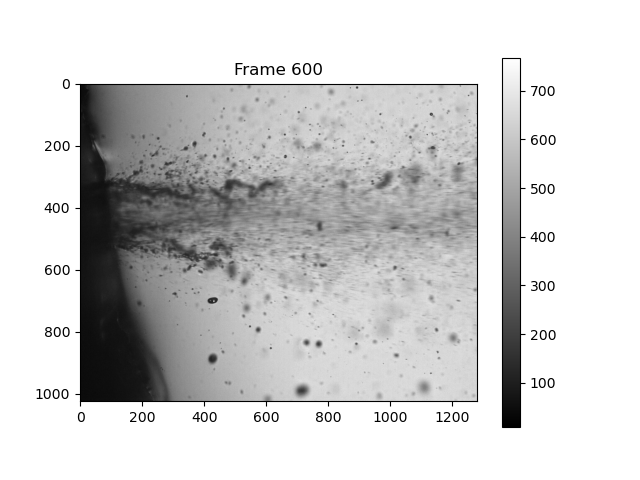

In [31]:
# Check images look OK
fig=plt.figure(); n=600
p=plt.imshow(I.arr[n,...],cmap='grey',vmax=768)
plt.colorbar(p); plt.title("Frame %i" % n);

## Find and remove background
First determine where the background data is in the image sequence.

In [59]:
# Normalised average pixel intensity in each frame
meanIntensity = np.nanmean(np.nanmean(I.arr,axis=-1),axis=-1)
meanIntensity /= np.nanmean(meanIntensity[:10])
sprayPeriod = np.where(meanIntensity<0.95)[0]
sprayPeriod = ( sprayPeriod.min()-100, sprayPeriod.max()+100 )

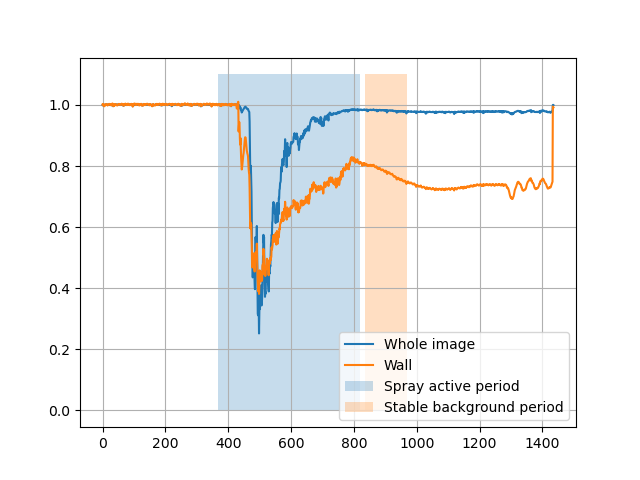

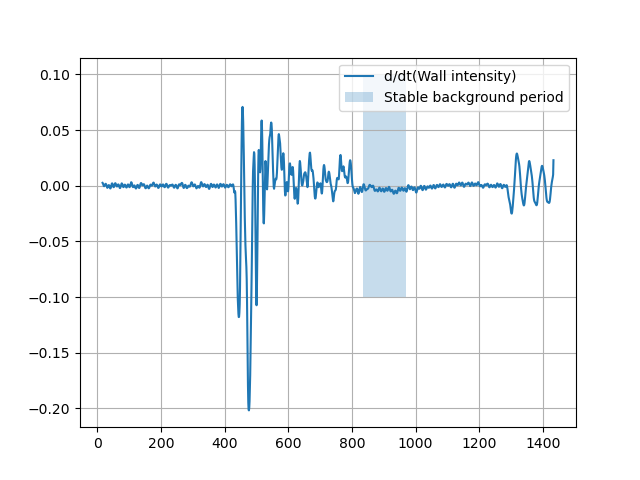

In [89]:
# Get suitable background images.
# This is a bit difficult for this experiment because the nozzle wobbles about during actuation.

# Let's have a look at the time period where the motion of the nozzle ( the left part of the image)
# is moving , compared to the entire frame.  Define the wall manually as x<200 px
wallIntensity = np.nanmean(np.nanmean(I.arr[...,:200],axis=-1),axis=-1)
wallIntensity /= np.nanmean(wallIntensity[:10])

# Calculate a smoothed time derivative of the wall intensity
filter_width=16
wallRateChange = np.diff(np.convolve(wallIntensity,np.hanning(filter_width)))

# Find the first contiguous region after the sprayPeriod where the gradient is small enough.
stableBackground = np.where(np.abs(wallRateChange[sprayPeriod[1]:]) < 1e-3)[0]
startBackground = np.nanmin(stableBackground)
endBackground = startBackground + np.where(np.diff(stableBackground[startBackground+10:]) >= 10)[0][0]
stableBackground = (startBackground+sprayPeriod[1], endBackground+sprayPeriod[1])

# Plot result.
fig=plt.figure()
plt.plot(meanIntensity, label='Whole image')
plt.plot(wallIntensity, label='Wall')
plt.fill_between(sprayPeriod,(1.1,1.1),alpha=.25,label='Spray active period');
plt.fill_between(stableBackground,(1.1,1.1),alpha=.25,label='Stable background period');
plt.legend(); plt.grid();

fig=plt.figure()
plt.plot(np.arange(filter_width,len(wallRateChange)-filter_width),\
         wallRateChange[filter_width:-filter_width], label='d/dt(Wall intensity)')
plt.fill_between(stableBackground,(-0.1,-0.1),(0.1,0.1),alpha=.25,label='Stable background period');
plt.grid(); plt.legend();

In [188]:
avgBkgnd = np.nanmean(I.arr[stableBackground[0]:stableBackground[1],...], axis=0).astype(float)
#avgBkgnd[...,400:] = np.nanmax(I.arr[...,400:],axis=0)
avgBkgnd[avgBkgnd<10]=10 # Floor on bkgnd intensity to avoid div by zero later.
avgBkgndMask = np.copy(avgBkgnd)
avgBkgndMask[avgBkgndMask<300]=np.nanmin(avgBkgndMask)

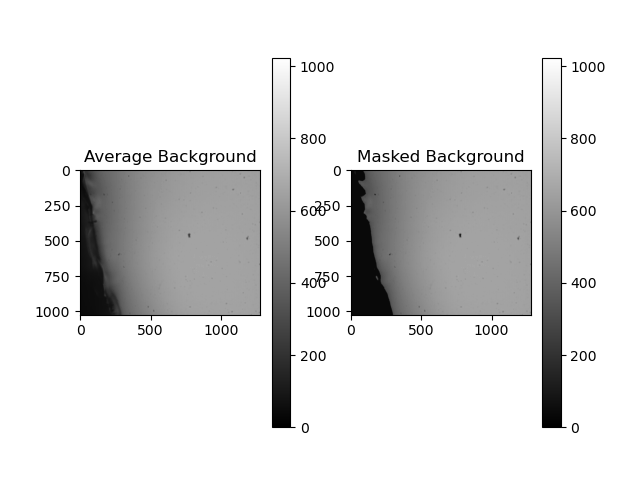

In [189]:
fig=plt.figure()
ax=fig.add_subplot(121)
p=ax.imshow(avgBkgnd,cmap='gray',vmin=0,vmax=1024); plt.colorbar(p); plt.title("Average Background");
ax=fig.add_subplot(122)
p=ax.imshow(avgBkgndMask,cmap='gray',vmin=0,vmax=1024); plt.colorbar(p); plt.title("Masked Background");


In [190]:
# Perform background removal
Inorm = 1 - I.arr[sprayPeriod[0]:sprayPeriod[1],...] / avgBkgndMask

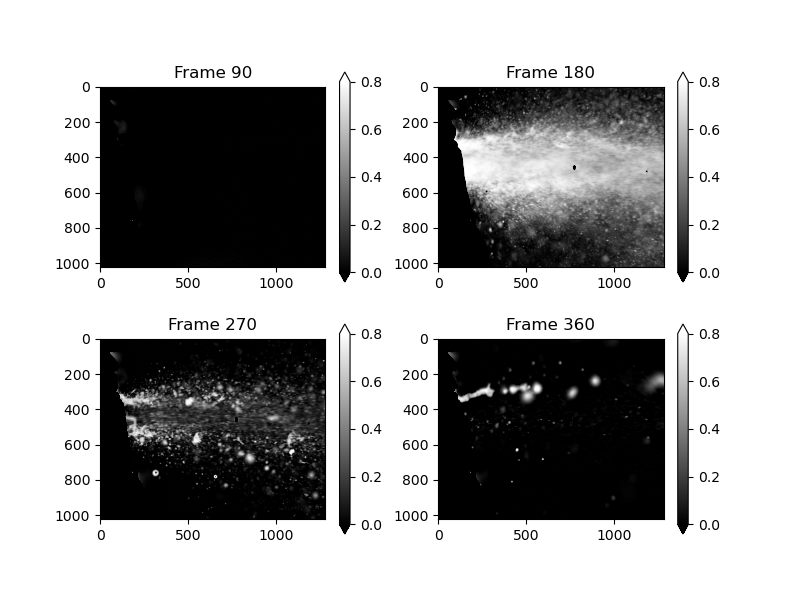

In [191]:
# Plot samples
fig=plt.figure(figsize=(8,6)); i=0
for n in np.linspace(Inorm.shape[0]*0.2,Inorm.shape[0]*0.8,4):
    ax=fig.add_subplot(221+i)
    p=ax.imshow(Inorm[int(n),...],cmap='gray',vmin=0,vmax=0.8)
    plt.colorbar(p,extend='both')
    plt.title('Frame %i' % n)
    i+=1

## Show statistics

In [192]:
meanSpray = np.nanmean(Inorm,axis=0)
stdSpray = np.nanstd(Inorm,axis=0)

meanSpray[meanSpray<0]=0
stdSpray[meanSpray<1e-3]=0 # mask

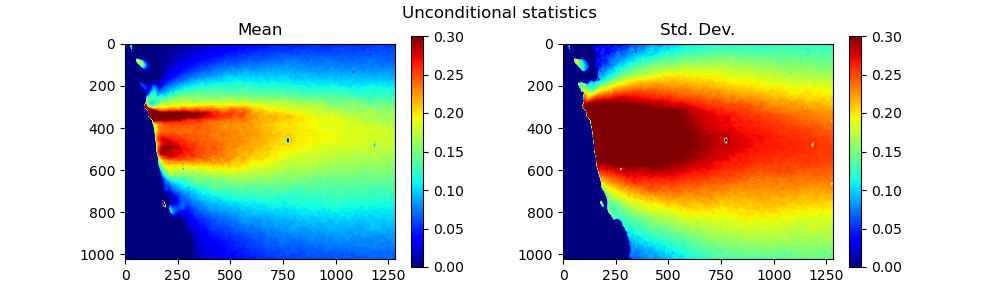

In [193]:
fig=plt.figure(figsize=(10,3))
plt.suptitle("Unconditional statistics")
ax=fig.add_subplot(121)
p=plt.imshow(meanSpray,cmap='jet',vmax=0.3);
plt.title("Mean"); plt.colorbar(p)
ax=fig.add_subplot(122)
p=plt.imshow(stdSpray,cmap='jet',vmax=0.3);
plt.title("Std. Dev."); plt.colorbar(p);
plt.subplots_adjust(wspace=0.3);

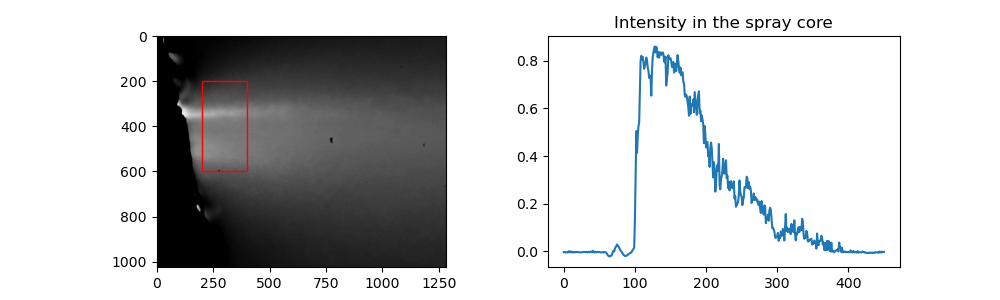

In [194]:
# Get core intensity to use as a conditional averaging requirement
import matplotlib.patches as patches

# Define core
x0 = 200; dx = 200
y0 = 200; dy = 400

coreIntensity = np.nanmean(np.nanmean(Inorm[:,y0:y0+dy,x0:x0+dx],axis=-1),axis=-1)

fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(121)
plt.imshow(meanSpray,cmap='gray');
rect = patches.Rectangle((x0,y0), dx, dy, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect);

ax=fig.add_subplot(122)
plt.plot(coreIntensity); plt.title("Intensity in the spray core");

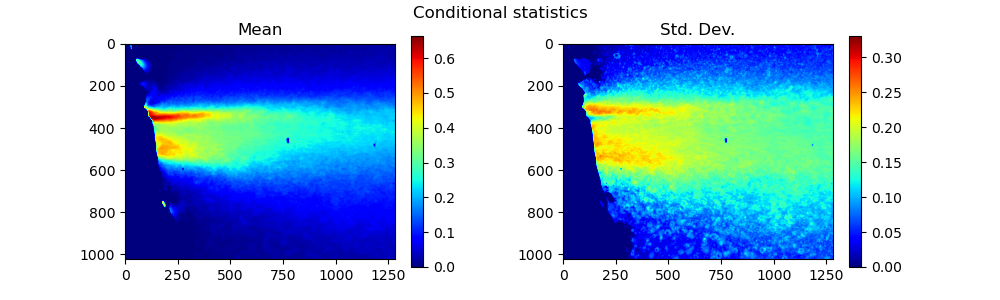

In [195]:
# Conditional statistics on spray core intensity being within certain range.
conditionalFilter = (coreIntensity<0.6) & (coreIntensity>0.1)

meanSprayC = np.nanmean(Inorm[conditionalFilter],axis=0)
stdSprayC = np.nanstd(Inorm[conditionalFilter],axis=0)

meanSprayC[meanSprayC<0]=0
stdSprayC[meanSprayC<1e-3]=0 # mask

fig=plt.figure(figsize=(10,3))
plt.suptitle("Conditional statistics")
ax=fig.add_subplot(121)
p=plt.imshow(meanSprayC,cmap='jet');
plt.title("Mean"); plt.colorbar(p)
ax=fig.add_subplot(122)
p=plt.imshow(stdSprayC,cmap='jet');
plt.title("Std. Dev."); plt.colorbar(p);
plt.subplots_adjust(wspace=0.3);

## Save movie for checking

In [ ]:
import imageio, tqdm

movieFile=os.path.splitext(filename)[0]+'.mp4'
print("Saving data as 8-bit to %s..." % movieFile)

Iscaled = 255*np.copy(Inorm)
Iscaled[Iscaled<0]=0
Iscaled[Iscaled>255]=255

writer = imageio.get_writer(movieFile, fps=25)
for n in tqdm.tqdm(range(Inorm.shape[0])):
    writer.append_data(Iscaled[n,...].astype('uint8'))
writer.close()

Saving data as 8-bit to noz4_1234ze_focus0.25_1khz_300ns_001.mp4...
